In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os

# Set your base directory path
base_dir = '/Users/apple/Desktop/hira/h-vgxe/dataset'

# Subdirectories
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Emotion classes (matching lowercase folder names)
categories = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Function to count images in each category
def count_images(directory):
    counts = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        if os.path.exists(category_path):
            counts[category.capitalize()] = len([f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
        else:
            counts[category.capitalize()] = 0
    return counts

# Print image counts
print("Training Set:", count_images(train_dir))
print("Test Set:", count_images(test_dir))

Training Set: {'Angry': 3995, 'Disgust': 436, 'Fear': 4097, 'Happy': 7215, 'Sad': 4830, 'Surprise': 3171, 'Neutral': 4965}
Test Set: {'Angry': 958, 'Disgust': 111, 'Fear': 1024, 'Happy': 1774, 'Sad': 1247, 'Surprise': 831, 'Neutral': 1233}


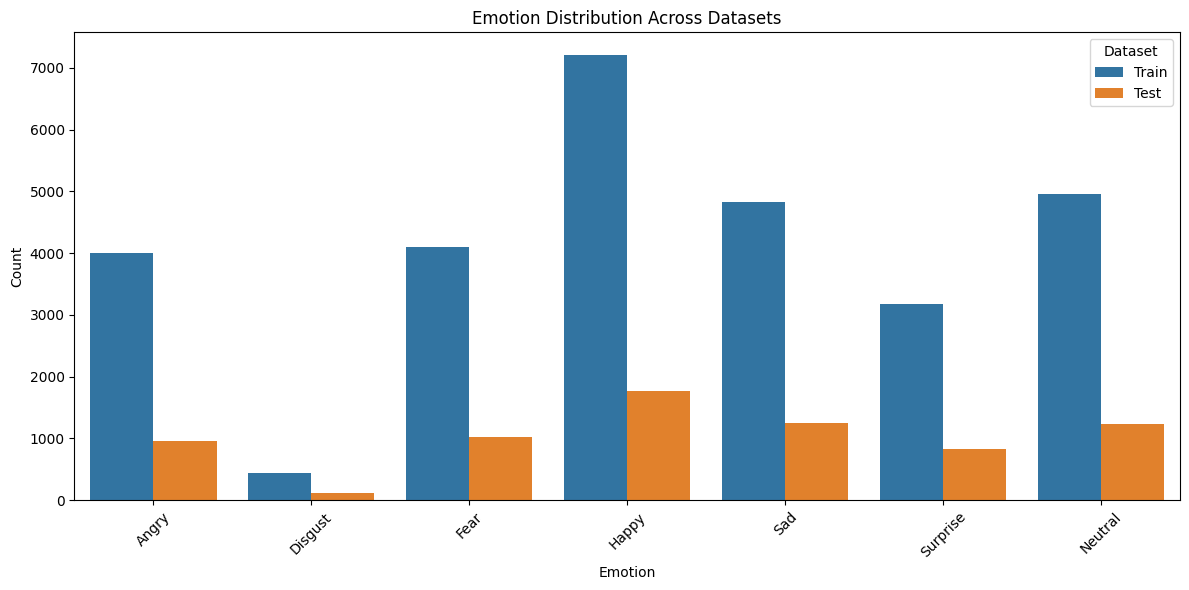

In [3]:
import pandas as pd

# Create a DataFrame for visualization
data = []
for dataset_name, dataset_dir in [('Train', train_dir), ('Test', test_dir)]:
    counts = count_images(dataset_dir)
    for emotion, count in counts.items():
        data.append({'Dataset': dataset_name, 'Emotion': emotion, 'Count': count})

df = pd.DataFrame(data)

# Plot using Seaborn with proper DataFrame structure
plt.figure(figsize=(12, 6))
sn.barplot(data=df, x='Emotion', y='Count', hue='Dataset')
plt.title('Emotion Distribution Across Datasets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
IMG_SIZE = 200
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of training data for validation
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


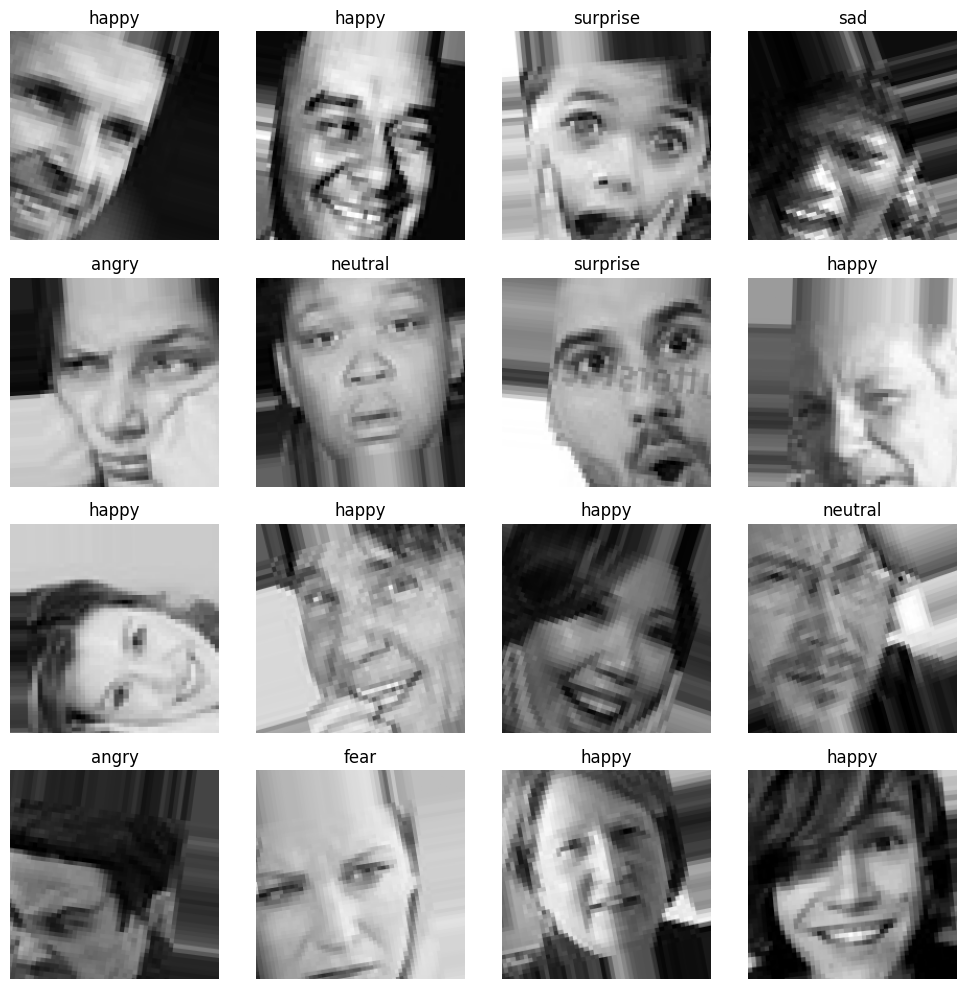

In [5]:
# Get a batch of augmented images
aug_images, aug_labels = next(train_generator)

# Plot
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(aug_images[i].squeeze(), cmap='gray')  # Remove channel dim for grayscale
    plt.title(list(train_generator.class_indices.keys())[np.argmax(aug_labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import AdamW

IMG_SIZE = 200
NUM_CLASSES = 7

# Load Xception base model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze layers
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Create the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    # Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    # Dropout(0.5),
    # Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    # Dropout(0.6),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-4), # Example AdamW
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.3, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_xception_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Summary
model.summary()

I0000 00:00:1745170933.175592      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745170933.176271      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,655 (80.58 MB)

 Trainable params: 9,203,527 (35.11 MB)

 Non-trainable params: 11,921,128 (45.48 MB)

In [7]:
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=16,
    callbacks=[early_stop, reduce_lr, checkpoint],
)

Epoch 1/16


I0000 00:00:1745170954.018145      88 service.cc:148] XLA service 0x7d040c015ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745170954.019969      88 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745170954.020006      88 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745170955.572061      88 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1745170963.346340      88 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745170963.484136      88 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1745170968.381080      88 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most onc

898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.3749 - loss: 1.8171
Epoch 1: val_accuracy improved from -inf to 0.54946, saving model to best_xception_model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 544s 572ms/step - accuracy: 0.3749 - loss: 1.8170 - val_accuracy: 0.5495 - val_loss: 1.4034 - learning_rate: 1.0000e-04
Epoch 2/16
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.5306 - loss: 1.4421
Epoch 2: val_accuracy improved from 0.54946 to 0.58066, saving model to best_xception_model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 304s 336ms/step - accuracy: 0.5306 - loss: 1.4421 - val_accuracy: 0.5807 - val_loss: 1.2975 - learning_rate: 1.0000e-04
Epoch 3/16
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.5757 - loss: 1.2989
Epoch 3: val_accuracy improved from 0.58066 to 0.60518, saving model to best_xception_model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 300s 332ms/step - accuracy: 0.5757 - loss: 1.2989 - val_accuracy: 0.6052 - val_loss: 1.1919 - learning_rate: 1.0000e-04
Epoch 4/1

In [ ]:

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\n Test Accuracy: {test_acc:.4f}")
print(f" Test Loss: {test_loss:.4f}")

3589/3589 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.6323 - loss: 1.0967

 Test Accuracy: 0.6751
 Test Loss: 0.9799


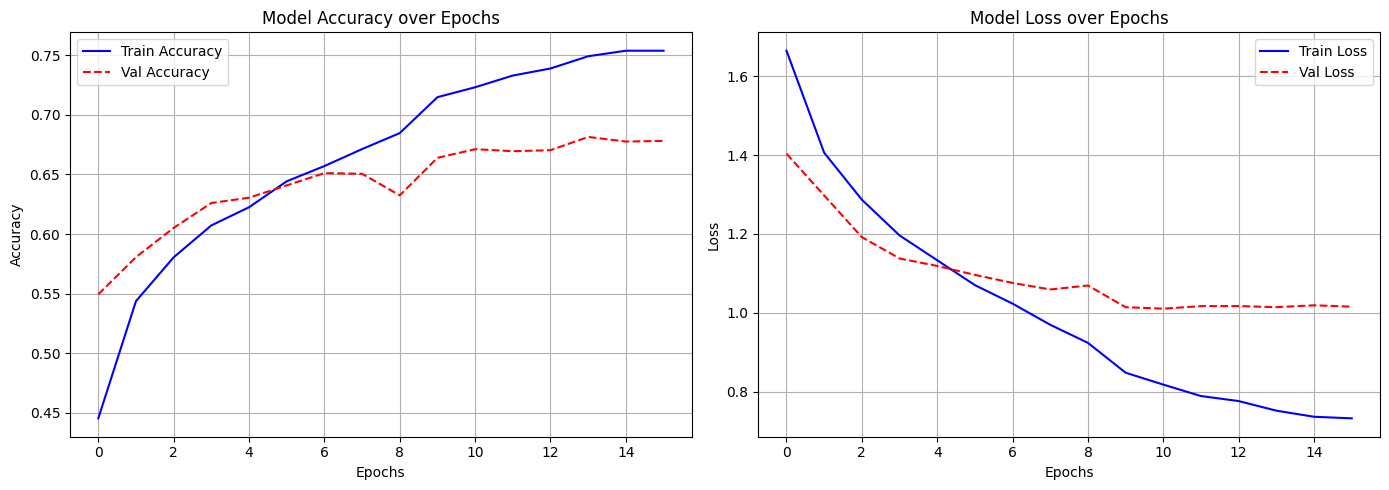

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Plot training and validation accuracy/loss
history = fine_tune_history.history

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], 'b',label='Train Accuracy')
plt.plot(history['val_accuracy'], 'r--',label='Val Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history['loss'], 'b' , label='Train Loss')
plt.plot(history['val_loss'], 'r--',label='Val Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

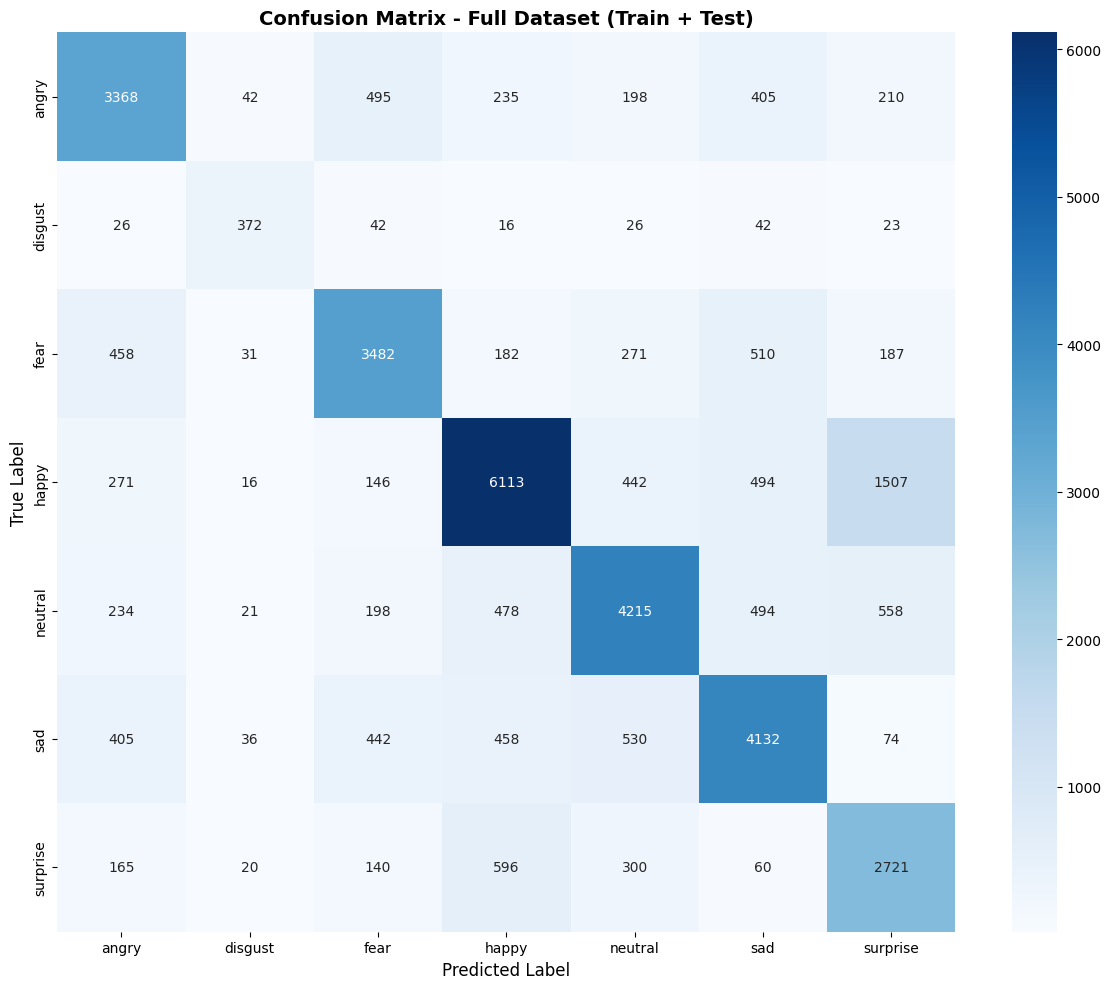

Classification Report:


              precision    recall  f1-score   support

       angry       0.68      0.68      0.68      4953
     disgust       0.70      0.68      0.69       547
        fear       0.68      0.68      0.68      5121
       happy       0.72      0.68      0.70      8989
     neutral       0.68      0.68      0.68      6198
         sad       0.68      0.68      0.68      6077
    surprise       0.66      0.68      0.67      4002

    accuracy                           0.68     35887
   macro avg       0.69      0.68      0.68     35887
weighted avg       0.69      0.68      0.68     35887



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n")
print(report)